In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(grid)
library('ggh4x')
library("cowplot")
library(patchwork)
library(rstatix)
library(ggpubr)
library(corrplot)

Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘cowplot’ was built under R version 4.3.3”
Warning message:
“package ‘patchwork’ was built under R version 4.3.3”

Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Warning message:
“package ‘rstatix’ was built under R version 4.3.3”

Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


Warning message:
“package ‘corrplot’ was built under R version 4.3.3”
corrplot 0.95 loaded



In [2]:
is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  
  if(luminance < 128){
  
  return('white')
      
  }else{return('black')}
}

# Read color hex code for cell types

In [3]:
color_annotation<-read.csv('/home//workspace/IHA_Figure_Revision/Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

# Read CompositeScore

In [4]:
df<-read.csv('/home//workspace/IHA_Figure_Revision/Figure1/04_CompositeScore/BRI_CompositeScore_Up.csv')

# Plotting

In [5]:
celltype_order<-c("Core naive CD8 T cell","CM CD8 T cell","GZMK+ CD27+ EM CD8 T cell","Naive CD4 Treg",
                 "Core naive CD4 T cell","CM CD4 T cell","GZMB- CD27- EM CD4 T cell","GZMB- CD27+ EM CD4 T cell")
df$celltype<-factor(df$celltype,levels=celltype_order)

In [6]:
df$`Age Group`=df$`AgeGroup`
df$`Age Group`=factor(df$`Age Group`,level=c('Young','Older'))


In [7]:
# there is one outlier we removed 
df<-df %>% group_by(celltype)  %>% filter(composite_score_sum_scaled_mean>min(composite_score_sum_scaled_mean))

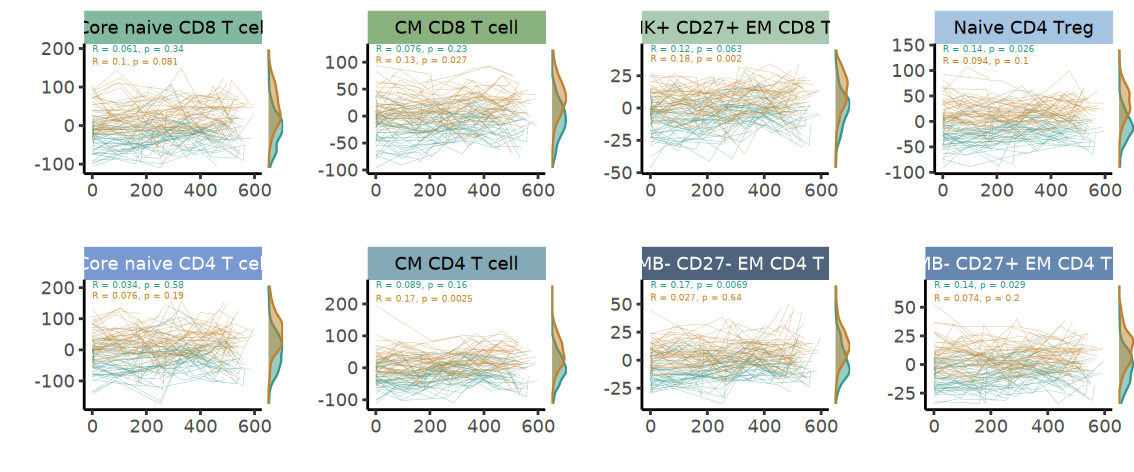

In [66]:
plot_list <- list()
for (selected_celltype in celltype_order) {
    df_sub <- df %>%
        filter(celltype == selected_celltype)
    max_value <- max(df_sub$composite_score_sum_scaled_mean, na.rm = TRUE)
df_sub$celltype<-gsub(" cell","",df_sub$celltype)
    p1 <- ggplot(df_sub, aes(sample.daysSinceFirstVisit, composite_score_sum_scaled_mean, color = AgeGroup)) +
        geom_line(aes(group = interaction(
            `Age Group`,
            subject.subjectGuid
        )), linewidth = 0.1, alpha = 0.5, linetype = 1) +
        ylab("") +
        theme_bw(base_size = 6) +
        theme(
            axis.line = element_line(colour = "black"),
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            panel.border = element_blank(), 
            panel.background = element_blank()
        ) +
        scale_color_manual(values = c(
            Older = "#bf812d",
            Young = "#35978f"
        ))  +geom_smooth(method = "lm", se = TRUE, linewidth = 0.3) +

  stat_cor(data = df_sub %>% filter(`Age Group` == "Older"),
           method = "spearman",
           label.x.npc = "left",
            label.y = max_value * 1.1,
           size = 1.76, color = '#bf812d') +
  stat_cor(data = df_sub %>% filter(`Age Group` == "Young"),
           method = "spearman",
           label.x.npc = "left",
           label.y = max_value * 1.37,
           size = 1.76, color = '#35978f') +
        facet_wrap2(~celltype, axes = "all", remove_labels = "all", ncol = 1, scale = "free_y") +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = adjustcolor(color_vector[selected_celltype], alpha.f = 0.8), color = NA),
            strip.text = element_text(color = is_dark_color(adjustcolor(color_vector[selected_celltype], alpha.f = 0.8)))
        ) +
        xlab("") +
        theme(legend.position = "none")+
    scale_y_continuous(expand = expansion(mult = c(0.1, 0.15)))

    p2 <- ggplot(df_sub, aes(composite_score_sum_scaled_mean, fill = `Age Group`, color = `Age Group`)) +
        geom_density(alpha = 0.5, linewidth = 0.5) +
        scale_fill_manual(values = c(Older = "#bf812d", Young = "#35978f")) +
        scale_color_manual(values = c(Older = "#bf812d", Young = "#35978f")) +
        coord_flip() +  scale_x_continuous(expand = expansion(mult = c(0.1, 0.15))) +

        theme_void(base_size = 6) +
        theme(legend.position = "none") +
        theme(plot.margin = margin(0, 0, 0, -1, "mm"))

    combined_plot <- plot_grid(p1, p2, ncol = 2, rel_widths = c(10, 0.4), align = "h", axis = "tb")
    plot_list[[selected_celltype]] <- combined_plot
}

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


In [10]:
df$RNA_Age_Metric_Up<-df$composite_score_sum_scaled_mean
write.csv(df %>% select(celltype,RNA_Age_Metric_Up,sample.daysSinceFirstVisit,AgeGroup),
          "/home//workspace/Source_Data/Fig1g.csv", row.names=FALSE) 

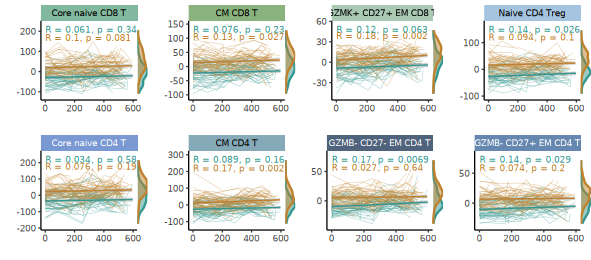

In [68]:
options(repr.plot.width = 115/25.4, repr.plot.height = 55/25.4)

p<-plot_grid(plot_list[[1]],plot_list[[2]],plot_list[[3]], plot_list[[4]],
             plot_list[[5]], plot_list[[6]],plot_list[[7]], plot_list[[8]], 
             ncol = 4, rel_widths = c(5, 5, 5, 5), 
             align = 'h', axis = 'lr')
p


In [70]:
ggsave('FigureG.pdf',p,width = 115/25.4,height = 55/25.4)